## Numerical method to evaluate Ts, and all the other output variables

In [44]:
import numpy as np
from scipy.optimize import root
import matplotlib.pyplot as plt
from equations import *
import pandas as pd

In [46]:
path = '../data/synthetic_dataset/'
file_list = ['SWin','SWout', 'LWin', 'Tair', 'RH_air', 'wind_speed', 'total_precipitation', 'snow_cover_fraction', 'surface_pressure']
variable_list = ['SWin','SWout', 'LWin', 'Tair', 'RH_air', 'u', 'prec', 'snow_cover', 'pressure']

for i, variable_name in enumerate(file_list):
    if i == 0: input_data = pd.read_csv(path + variable_name + '.csv', index_col="time", parse_dates=True)
    else: input_data[variable_list[i]] = pd.read_csv(path + variable_name + '.csv', index_col="time", parse_dates=True)[variable_list[i]]

#data

### Without constraint on Ts

In [23]:
# Function to solve for Ts at each time step
def solve_Ts(SWin, SWout, LWin, Tair, RH_air, u, prec, snow_cover):
    
    # Define the equation to solve
    def equation_system(Ts):
        
        LWout = longwave_out(Ts)
        SH = sensible_heat_flux(u, Ts, Tair)
        RH_s = surface_relative_humidity(RH_air, Ts, Tair, prec, snow_cover, u)
        q_s = specific_humidity(Ts, RH_s)
        q_air = specific_humidity(Ts, RH_air)
        LE = latent_heat_flux(u, q_s, q_air)
        #energy = energy_balance(SWin, SWout, LWin, LWout, SH, LE)
        #print(f"Energy balance for Ts={Ts}: {energy}")

        return energy_balance(SWin, SWout, LWin, LWout, SH, LE)

    # Define constraints
    #def constraint(Ts):
        # Limit Ts to be within a certain range of Tair
        # For example, Ts should not be more than 20°C higher or lower than Tair
        #return min(max(Tair - 20, Ts), Tair + 20) - Ts

    """
    def T_constraint(Ts):
        # Avoid Ts, when evaluated numerically, to be too far off compared to the Tair
        if snow_cover > 0.5:  # High snow cover: limit Ts deviation
          return max(min(Ts, Tair + 2), Tair - 2)  # Allow a 2 K deviation from Tair
        elif prec > 0:  # During precipitation: keep Ts closer to Tair
          return max(min(Ts, Tair + 5), Tair - 5)  # Allow a 5 K deviation from Tair
        else:  # No snow/precip: allow more variability
          return max(min(Ts, Tair + 10), Tair - 10)  # Allow up to 10 K deviation"""

    # Initial guess for Ts (e.g., ambient air temperature)
    initial_guess = Tair

    # Solve the equation with constraints
    #solution = root(lambda x: [equation_system(x[0]), constraint(x[0])], [initial_guess])
    solution = root(equation_system, initial_guess)
    
    # Check if the solution converged
    if solution.success:
        return solution.x[0]
    else:
        raise ValueError("Solution did not converge")


In [25]:
def calculate_surface_temperatures(df):
    """
    Calculate surface temperatures using the time series data from a DataFrame.

    Parameters:
        df (DataFrame): DataFrame with columns: 'SWin', 'SWout', 'LWin', 'Tair', 'u', 'q_air', 'RHs'

    Returns:
        np.array: Array of calculated surface temperatures (Ts) for each row in the DataFrame.
    """
    Ts_values = []
    for _, row in df.iterrows():
        Ts = solve_Ts(
            SWin=row['SWin'], 
            SWout=row['SWout'], 
            LWin=row['LWin'], 
            Tair=row['Tair'], 
            u=row['u'], 
            RH_air=row['RH_air'], 
            prec =row['prec'], 
            snow_cover =row['snow_cover']
        )
        Ts_values.append(Ts)
    return pd.DataFrame({'Ts': Ts_values}, index=df.index)#np.array(Ts_values)

# Example: Calculate Ts for each time step
Ts_values = calculate_surface_temperatures(input_data)

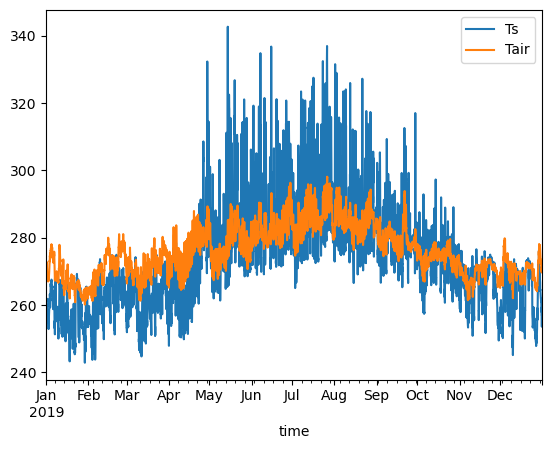

In [29]:
Ts_values.plot()

input_data['Tair'].plot(label = 'Tair')
plt.legend()

### With constraint on Ts (+/- 15 °C from Tair)

In [56]:
from scipy.optimize import minimize

def solve_Ts(SWin, SWout, LWin, Tair, RH_air, u, prec, snow_cover, pressure = 894.1191):
    # Define the equation to minimize (energy balance should approach 0)
    def equation_system(Ts):
        LWout = longwave_out(Ts[0])
        SH = sensible_heat_flux(u, Ts[0], Tair)
        RH_s = surface_relative_humidity(RH_air, Ts[0], Tair, prec, snow_cover, u)
        q_s = specific_humidity(Ts[0], RH_s, pressure)
        q_air = specific_humidity(Ts[0], RH_air, pressure)
        LE = latent_heat_flux(u, q_s, q_air)
        return energy_balance(SWin, SWout, LWin, LWout, SH, LE)**2  # Squared for minimization

    # Bounds for Ts: within ±20°C of Tair
    T_constrain = 15
    Ts_bounds = [(Tair - T_constrain, Tair + T_constrain)]

    # Initial guess for Ts
    initial_guess = [Tair]

    # Minimize the energy balance function
    result = minimize(equation_system, initial_guess, bounds=Ts_bounds, method='L-BFGS-B')

    # Check if the solution converged
    if result.success:
        return result.x[0]
    else:
        raise ValueError("Solution did not converge")

In [69]:
def calculate_surface_temperatures(df, verbose=True):
    Ts_values = []
    non_converge_count = 0  # Initialize the counter for non-convergences
    
    for idx, row in df.iterrows():
        try:
            Ts = solve_Ts(
                SWin=row['SWin'], 
                SWout=row['SWout'], 
                LWin=row['LWin'], 
                Tair=row['Tair'], 
                u=row['u'], 
                RH_air=row['RH_air'], 
                prec=row['prec'], 
                snow_cover=row['snow_cover'],
                pressure=row['pressure']
            )
            Ts_values.append(Ts)
        except ValueError as e:
            non_converge_count += 1  # Increment the counter
            if verbose:
                print(f"{e} at index {idx}: assigning to Ts the previous hour value ({round(Ts_values[-1], 2)})")
            Ts_values.append(Ts_values[-1])  # Assign the previous value
    
    print(f"1nNumerical method of Ts - solution did not converge {non_converge_count} times. \nTs values filled with the respectively previous value in the time series.")
    
    return pd.DataFrame({'Ts': Ts_values}, index=df.index)

# Example usage
Ts_values = calculate_surface_temperatures(input_data)


Solution did not converge at index 2019-01-04 12:00:00: assigning to Ts the previous hour value (266.72)
Solution did not converge at index 2019-01-10 14:00:00: assigning to Ts the previous hour value (266.98)
Solution did not converge at index 2019-02-13 04:00:00: assigning to Ts the previous hour value (266.03)
Solution did not converge at index 2019-02-24 22:00:00: assigning to Ts the previous hour value (261.64)
Solution did not converge at index 2019-02-24 23:00:00: assigning to Ts the previous hour value (261.64)
Solution did not converge at index 2019-02-25 08:00:00: assigning to Ts the previous hour value (263.37)
Solution did not converge at index 2019-02-25 23:00:00: assigning to Ts the previous hour value (265.19)
Solution did not converge at index 2019-07-04 19:00:00: assigning to Ts the previous hour value (285.89)
Solution did not converge at index 2019-11-05 03:00:00: assigning to Ts the previous hour value (263.01)
Solution did not converge at index 2019-11-28 20:00:00:

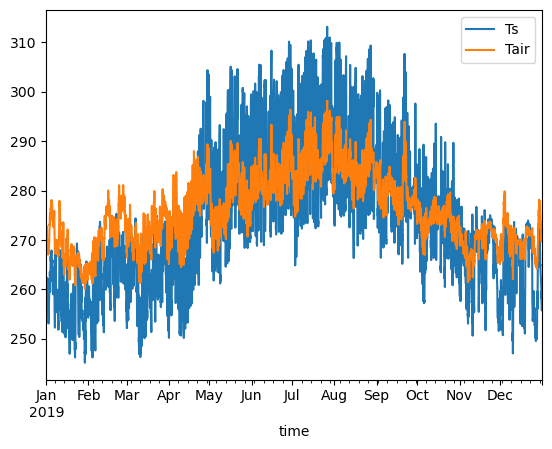

In [71]:
Ts_values.plot()

input_data['Tair'].plot(label = 'Tair')
plt.legend()

## Evaluate all the other output variables

In [42]:
output_data = pd.DataFrame(index=input_data.index)

output_data['Ts'] = Ts_values
output_data['RH_s'] = surface_relative_humidity(input_data['RH_air'], output_data['Ts'], 
                                                input_data['Tair'], input_data['prec'], 
                                                input_data['snow_cover'], input_data['u'])
output_data['q_s'] = specific_humidity(output_data['Ts'], output_data['RH_s'])
output_data['q_air'] = specific_humidity(output_data['Ts'], input_data['RH_air'])
output_data['LWout'] = longwave_out(output_data['Ts'])
output_data['SH'] = sensible_heat_flux(input_data['u'], output_data['Ts'], input_data['Tair'])
output_data['LE'] = latent_heat_flux(input_data['u'], output_data['q_s'], output_data['q_air'])
output_data

,Ts,RH_s,q_s,q_air,LWout,SH,LE
time,,,,,,,
2019-01-01 00:00:00,261.94138,0.839388,-1.743023,-1.745538,258.923362,-99.993868,93.843615
2019-01-01 01:00:00,262.01923,0.833513,-1.743615,-1.746165,259.231312,-123.938216,117.907627
2019-01-01 02:00:00,262.19520,0.810702,-1.746229,-1.748926,259.928404,-145.994522,146.940164
2019-01-01 03:00:00,262.56476,0.774004,-1.750616,-1.753576,261.396965,-162.993846,180.005235
2019-01-01 04:00:00,262.64880,0.722155,-1.758512,-1.761945,261.731791,-182.110817,233.297571
...,...,...,...,...,...,...,...
2019-12-31 19:00:00,262.52180,0.778796,-1.750009,-1.752931,261.225932,-82.919992,90.432141
2019-12-31 20:00:00,262.46268,0.804598,-1.746558,-1.749286,260.990698,-63.679497,64.812126
2019-12-31 21:00:00,262.93790,0.821260,-1.743554,-1.746141,262.886057,-89.230902,86.130986


In [44]:
#Path to allocate data
folder_path = "../data/synthetic_dataset/"

# List of variables with a time dimension
variables = [var for var in output_data.columns]

# Save each variable as a separate CSV file
for var in variables:
    # Convert to a DataFrame for easier CSV export
    df = output_data[var].to_frame()
    # Drop NaN values (if any) to keep the CSV clean
    #df = df.dropna()
    # Save to CSV
    df.to_csv(folder_path+f"{var}.csv")


print("Data successfully saved as individual CSV files in data/synthetic_dataset.")

Data successfully saved as individual CSV files in data/synthetic_dataset.


## Appendix: why it makes sense that Ts has a bigger amplitude than Tair
credits: Perplexity.ai

it actually does make sense for the surface temperature to have a larger amplitude than air temperature in a time series. Here's why:
Thermal properties: The Earth's surface (soil, rock, vegetation, etc.) has different thermal properties compared to air. It typically has a lower specific heat capacity, meaning it can heat up and cool down more quickly than air.
Direct solar radiation: The surface directly absorbs solar radiation during the day, causing it to heat up more rapidly and to higher temperatures than the air above it. At night, the surface radiates heat more efficiently than air, allowing it to cool more quickly.
Atmospheric buffering: The air temperature is buffered by various factors such as wind, humidity, and atmospheric mixing, which tend to moderate temperature extremes. The surface doesn't benefit from these buffering effects to the same extent.
Diurnal cycle: During a typical day-night cycle, the surface temperature often shows a more pronounced variation:
During the day, especially under clear sky conditions, the surface can become much warmer than the air above it.
At night, especially under clear, calm conditions, the surface can cool more rapidly than the air through radiative cooling.
Urban heat island effect: In urban areas, surfaces like asphalt and concrete can reach much higher temperatures during the day and cool more at night compared to air temperatures.
Microclimates: Surface temperatures can vary significantly over short distances due to factors like shading, moisture content, and surface type, leading to larger local temperature amplitudes.
Seasonal effects: On a seasonal scale, surfaces exposed to direct sunlight can show larger temperature swings than air temperatures, especially in areas with high solar radiation and low atmospheric moisture.
Measurement considerations: Surface temperature is often measured by infrared thermometers or satellite sensors, which capture the skin temperature of the surface. This can show more extreme values than air temperature measured at standard heights (usually 1.5-2 meters above the ground).
Given these factors, it is quite common and expected for surface temperature to show larger amplitudes than air temperature in many environments. This larger amplitude in surface temperature is an important factor in many environmental and ecological processes, including energy balance, evapotranspiration, and ecosystem dynamics.